In [1]:
from models import Generator, Discriminator
from torch.optim import Adam
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from custom_dataset import CustomSequenceDataset
from tqdm import tqdm
from utils import get_device, plot_loss_curve


In [2]:
def train(
    generator,
    discriminator,
    gen_optimizer,
    disc_optimizer,
    train_loader,
    epochs,
    vocab_size,
    device="cpu",
    temperature=0.01,
):
    generator_losses = []
    discriminator_losses = []
    for epoch in range(1, epochs + 1):
        print(f"Epoch {epoch} / {epochs}")

        gloss = 0.0
        dloss = 0.0
        for data, labels in tqdm(train_loader):
            # print(labels)

            # encode data to one-hot encoding
            data = F.one_hot(data.long(), vocab_size).float().to(device)

            labels = labels.long().to(device)

            # Train Discriminator
            disc_optimizer.zero_grad()
            # generate random noise
            latent_dim = generator.latent_dim
            z = torch.randn(data.shape[0], latent_dim).to(device)
            # generate fake data
            gen_data = generator(z, labels)

            # print("gen data shape", gen_data.shape)

            # perform discrete categorical sampling
            gen_data = F.gumbel_softmax(gen_data, tau=0.1, hard=False)

            # feed real data to discriminator
            disc_real = discriminator(data, labels)

            # feed fake data to discriminator
            disc_fake = discriminator(gen_data.detach(), labels)

            # compute discriminator loss
            disc_loss = -torch.mean(torch.log(disc_real) + torch.log(1 - disc_fake))

            dloss += disc_loss.item()


            # backward pass
            disc_loss.backward()

            # update discriminator weights
            disc_optimizer.step()

            # Train Generator
            gen_optimizer.zero_grad()
            z = torch.randn(data.shape[0], latent_dim).to(device)

            # generate fake data
            gen_data = generator(z, labels)

            # perform discrete categorical sampling
            # print("gen data shape", gen_data.shape)
            gen_data = F.gumbel_softmax(gen_data, tau=temperature, hard=False, dim=-1)

            # feed fake data to discriminator
            disc_fake = discriminator(gen_data, labels)

            # compute generator loss
            gen_loss = torch.mean(1 - torch.log(disc_fake))

            gloss += gen_loss.item()


            # backward pass
            gen_loss.backward()

            # update generator weights
            gen_optimizer.step()

        n_batches = len(train_loader)
        dloss = torch.round(torch.tensor(dloss), decimals=4)
        gloss = torch.round(torch.tensor(gloss), decimals=4)

        discriminator_losses.append(dloss)
        generator_losses.append(gloss)


        print(f"D Loss: {disc_loss.item():.4f}, G Loss: {gen_loss.item():.4f}")
    
    return generator_losses, discriminator_losses


    


In [3]:
# hyperparameters of the generator and discriminator of the GAN model
latent_dim = 100
hidden_dim = 128
vocab_size = 50
seq_len = 100
output_dim = vocab_size
embed_dim = 10
dropout = 0.3
batch_size = 32
n_samples = 1000
num_classes = 2
lr = 2e-6
epochs = 50
# criterion = nn.BCELoss()
criterion = F.cross_entropy
device = get_device()

gen = Generator(latent_dim, seq_len, hidden_dim, output_dim, embed_dim, dropout, conditional_info=True, num_classes=num_classes).to(
    device
)
# gen = Gen(latent_dim, hidden_dim, seq_len, output_dim, embed_dim, dropout).to(device)

disc = Discriminator(vocab_size,seq_len, hidden_dim, embed_dim, dropout, conditional_info=True, num_classes=num_classes).to(device)

gen_optimizer = Adam(gen.parameters(), lr=lr, betas=(0.5, 0.999))

disc_optimizer = Adam(disc.parameters(), lr=lr, betas=(0.5, 0.999))




In [4]:

input_data = torch.randint(0, vocab_size, (n_samples, seq_len))
input_labels = torch.randint(0, num_classes, (n_samples,))
train_dataset = CustomSequenceDataset(input_data, input_labels)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


In [5]:

# note that the temperature is set to any value between 0 and 1. 
g_losses ,d_losses =  train(
    gen,
    disc,
    gen_optimizer,
    disc_optimizer,
    train_loader,
    epochs,
    vocab_size,
    device=device,
    temperature=0.1,
)


Epoch 1 / 50


100%|██████████| 32/32 [00:02<00:00, 12.08it/s]


D Loss: 1.3844, G Loss: 1.6990
Epoch 2 / 50


100%|██████████| 32/32 [00:01<00:00, 23.19it/s]


D Loss: 1.3815, G Loss: 1.7010
Epoch 3 / 50


100%|██████████| 32/32 [00:01<00:00, 22.77it/s]


D Loss: 1.3881, G Loss: 1.6995
Epoch 4 / 50


100%|██████████| 32/32 [00:01<00:00, 23.33it/s]


D Loss: 1.3854, G Loss: 1.7042
Epoch 5 / 50


100%|██████████| 32/32 [00:01<00:00, 23.39it/s]


D Loss: 1.3815, G Loss: 1.7020
Epoch 6 / 50


100%|██████████| 32/32 [00:01<00:00, 23.58it/s]


D Loss: 1.3839, G Loss: 1.7054
Epoch 7 / 50


100%|██████████| 32/32 [00:01<00:00, 23.36it/s]


D Loss: 1.3790, G Loss: 1.6998
Epoch 8 / 50


100%|██████████| 32/32 [00:01<00:00, 22.01it/s]


D Loss: 1.3927, G Loss: 1.7068
Epoch 9 / 50


100%|██████████| 32/32 [00:01<00:00, 22.87it/s]


D Loss: 1.3819, G Loss: 1.7017
Epoch 10 / 50


100%|██████████| 32/32 [00:01<00:00, 23.09it/s]


D Loss: 1.3842, G Loss: 1.7053
Epoch 11 / 50


100%|██████████| 32/32 [00:01<00:00, 23.58it/s]


D Loss: 1.3835, G Loss: 1.7054
Epoch 12 / 50


100%|██████████| 32/32 [00:01<00:00, 23.41it/s]


D Loss: 1.3956, G Loss: 1.7054
Epoch 13 / 50


100%|██████████| 32/32 [00:01<00:00, 23.66it/s]


D Loss: 1.3856, G Loss: 1.7038
Epoch 14 / 50


100%|██████████| 32/32 [00:01<00:00, 23.59it/s]


D Loss: 1.3862, G Loss: 1.7035
Epoch 15 / 50


100%|██████████| 32/32 [00:01<00:00, 21.82it/s]


D Loss: 1.3825, G Loss: 1.7015
Epoch 16 / 50


100%|██████████| 32/32 [00:01<00:00, 22.95it/s]


D Loss: 1.3892, G Loss: 1.7020
Epoch 17 / 50


100%|██████████| 32/32 [00:01<00:00, 23.32it/s]


D Loss: 1.3886, G Loss: 1.6996
Epoch 18 / 50


100%|██████████| 32/32 [00:01<00:00, 23.49it/s]


D Loss: 1.3829, G Loss: 1.7072
Epoch 19 / 50


100%|██████████| 32/32 [00:01<00:00, 23.56it/s]


D Loss: 1.3833, G Loss: 1.7025
Epoch 20 / 50


100%|██████████| 32/32 [00:01<00:00, 26.17it/s]


D Loss: 1.3910, G Loss: 1.6985
Epoch 21 / 50


100%|██████████| 32/32 [00:01<00:00, 24.26it/s]


D Loss: 1.3872, G Loss: 1.7067
Epoch 22 / 50


100%|██████████| 32/32 [00:01<00:00, 22.30it/s]


D Loss: 1.3828, G Loss: 1.6986
Epoch 23 / 50


100%|██████████| 32/32 [00:01<00:00, 19.15it/s]


D Loss: 1.3938, G Loss: 1.6994
Epoch 24 / 50


100%|██████████| 32/32 [00:01<00:00, 22.52it/s]


D Loss: 1.3837, G Loss: 1.6992
Epoch 25 / 50


100%|██████████| 32/32 [00:01<00:00, 22.63it/s]


D Loss: 1.3857, G Loss: 1.7022
Epoch 26 / 50


100%|██████████| 32/32 [00:01<00:00, 22.09it/s]


D Loss: 1.3896, G Loss: 1.7063
Epoch 27 / 50


100%|██████████| 32/32 [00:01<00:00, 22.83it/s]


D Loss: 1.3876, G Loss: 1.6991
Epoch 28 / 50


100%|██████████| 32/32 [00:01<00:00, 23.04it/s]


D Loss: 1.3904, G Loss: 1.6972
Epoch 29 / 50


100%|██████████| 32/32 [00:01<00:00, 23.22it/s]


D Loss: 1.3877, G Loss: 1.7113
Epoch 30 / 50


100%|██████████| 32/32 [00:01<00:00, 23.50it/s]


D Loss: 1.3879, G Loss: 1.7015
Epoch 31 / 50


100%|██████████| 32/32 [00:01<00:00, 23.61it/s]


D Loss: 1.3895, G Loss: 1.7015
Epoch 32 / 50


100%|██████████| 32/32 [00:01<00:00, 23.51it/s]


D Loss: 1.3818, G Loss: 1.7045
Epoch 33 / 50


100%|██████████| 32/32 [00:01<00:00, 18.07it/s]


D Loss: 1.3840, G Loss: 1.7070
Epoch 34 / 50


100%|██████████| 32/32 [00:01<00:00, 16.11it/s]


D Loss: 1.3858, G Loss: 1.7017
Epoch 35 / 50


100%|██████████| 32/32 [00:01<00:00, 22.37it/s]


D Loss: 1.3782, G Loss: 1.6995
Epoch 36 / 50


100%|██████████| 32/32 [00:01<00:00, 21.44it/s]


D Loss: 1.3816, G Loss: 1.7022
Epoch 37 / 50


100%|██████████| 32/32 [00:01<00:00, 21.02it/s]


D Loss: 1.3893, G Loss: 1.6995
Epoch 38 / 50


100%|██████████| 32/32 [00:01<00:00, 22.82it/s]


D Loss: 1.3831, G Loss: 1.7105
Epoch 39 / 50


100%|██████████| 32/32 [00:01<00:00, 22.76it/s]


D Loss: 1.3871, G Loss: 1.7018
Epoch 40 / 50


100%|██████████| 32/32 [00:01<00:00, 22.79it/s]


D Loss: 1.3862, G Loss: 1.7030
Epoch 41 / 50


100%|██████████| 32/32 [00:01<00:00, 21.72it/s]


D Loss: 1.3903, G Loss: 1.6998
Epoch 42 / 50


100%|██████████| 32/32 [00:01<00:00, 21.60it/s]


D Loss: 1.3956, G Loss: 1.6970
Epoch 43 / 50


100%|██████████| 32/32 [00:01<00:00, 21.61it/s]


D Loss: 1.3859, G Loss: 1.7054
Epoch 44 / 50


100%|██████████| 32/32 [00:01<00:00, 22.09it/s]


D Loss: 1.3865, G Loss: 1.6992
Epoch 45 / 50


100%|██████████| 32/32 [00:01<00:00, 19.92it/s]


D Loss: 1.3911, G Loss: 1.7007
Epoch 46 / 50


100%|██████████| 32/32 [00:01<00:00, 19.61it/s]


D Loss: 1.3899, G Loss: 1.7015
Epoch 47 / 50


100%|██████████| 32/32 [00:01<00:00, 19.63it/s]


D Loss: 1.3818, G Loss: 1.6988
Epoch 48 / 50


100%|██████████| 32/32 [00:01<00:00, 20.10it/s]


D Loss: 1.3888, G Loss: 1.7003
Epoch 49 / 50


100%|██████████| 32/32 [00:01<00:00, 19.34it/s]


D Loss: 1.3862, G Loss: 1.6970
Epoch 50 / 50


100%|██████████| 32/32 [00:01<00:00, 19.74it/s]

D Loss: 1.3899, G Loss: 1.7008


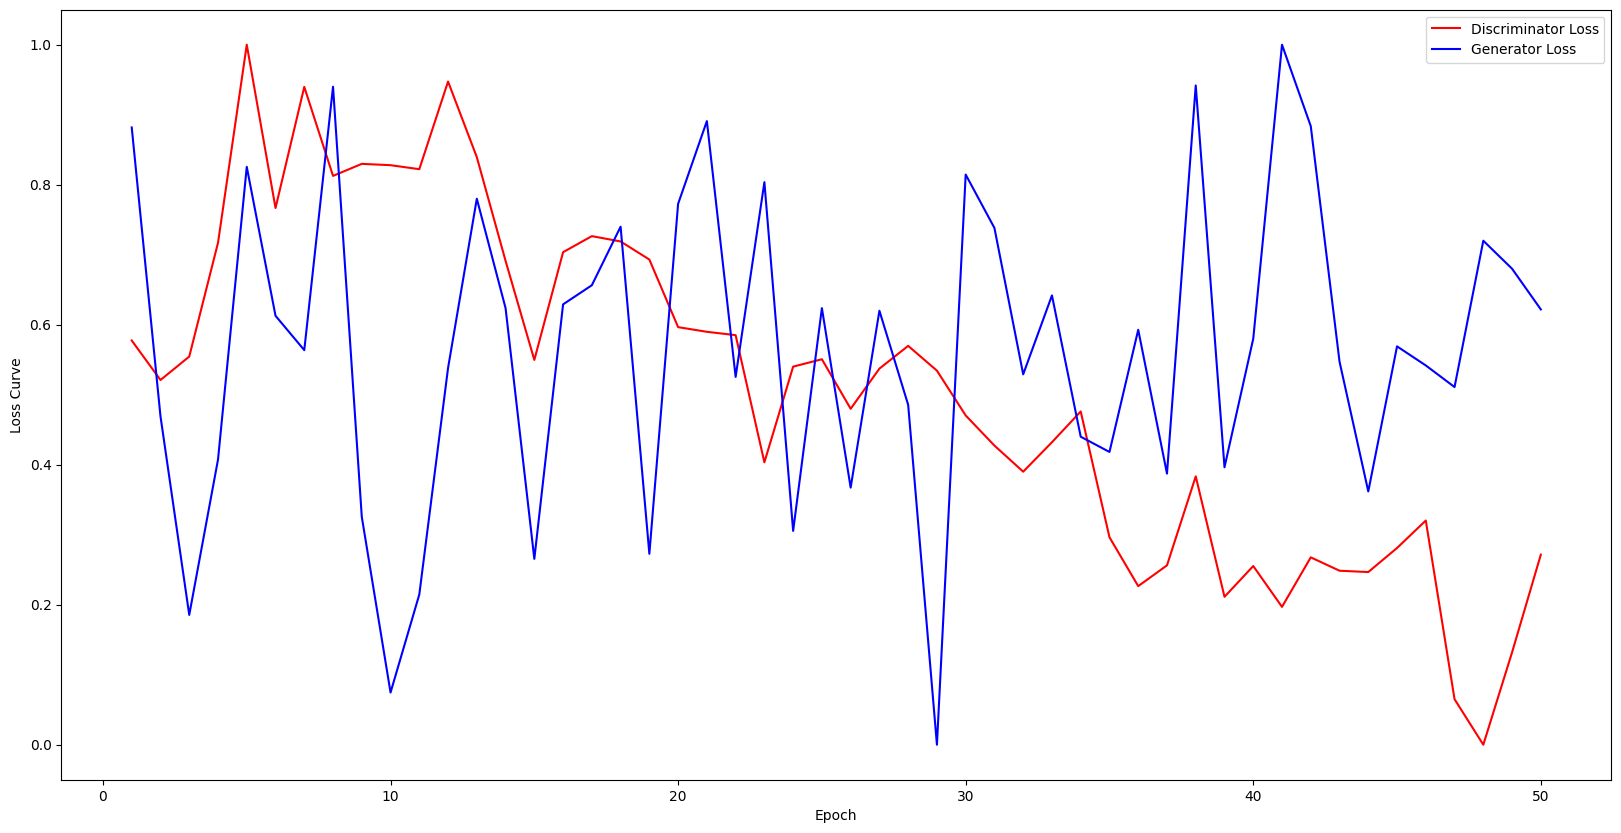

In [6]:
plot_loss_curve(g_losses, d_losses, epochs)

##  generate fake samples


In [7]:
fake_labels = torch.randint(0, num_classes, (n_samples,), dtype=torch.long)
z = torch.randn((n_samples, seq_len))


# set generator to eval mode
gen.eval()

fake_data = gen(z.to(device), fake_labels.to(device))

# print the generated data: if the data contains nan values, it means that there is gradient explosion, or other issues. To avoid such problems, change the termperature value to be between 0.1 and 0.5. Also, trying changing the learning rate to be between 5e-6 and 1e-4. Of course, this is just a suggestion. You might experiment with other values if you want, and report your findings.
print(fake_data[0])


tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0576, 0.0000, 0.0810,  ..., 0.0391, 0.0000, 0.0000],
        [0.0000, 0.0443, 0.0000,  ..., 0.0095, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0086, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0719, 0.0000, 0.0000,  ..., 0.0039, 0.0707, 0.0000],
        [0.0000, 0.0000, 0.0508,  ..., 0.0741, 0.0747, 0.0000]],
       device='mps:0', grad_fn=<SelectBackward0>)


In [8]:
# get the generated samples as tokens (this are a sequence tokens or words / characters, represented by integers .)
fake_samples = torch.argmax(fake_data, dim=-1).cpu().numpy()

# now, let's see one sequence generated
fake_samples[10]

array([ 0, 20, 17, 37,  0, 15,  7,  0, 48,  5, 12, 38,  0, 24, 16,  3,  0,
        0,  0, 23,  0, 27, 13,  0, 29, 32, 49,  5, 32, 10, 49,  0,  0,  0,
       11,  0,  0,  0,  0,  0,  0, 36, 33,  0, 14,  0, 35,  8, 14, 11, 13,
       10,  0,  0,  0,  0,  2, 48, 26,  4,  0,  0,  3, 36,  0,  0, 45,  0,
       22, 35,  0,  0,  0, 15,  0, 17,  0, 16, 48, 28,  0, 23,  0,  0,  0,
       43,  3,  0, 34, 35, 31,  0,  0,  0, 48, 35, 10, 24,  9, 39])